# Multi-Layer Perceptron Model Investigation


In [3]:
# Import required modules

import pandas as pd
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Pre-processing

In [4]:
# Read in Data
df = pd.read_csv('data/data.csv')
cpi = pd.read_csv('data/cpi.csv')
df.head()
cpi.head()

,Quarter,CPI
0,2021Q1,117.9
1,2021Q2,118.8
2,2021Q3,119.7
3,2021Q4,121.3
4,2022Q1,123.9


In [5]:
# Assign priority: 'completed' gets highest priority (lowest number)

df['status_priority'] = df['BStatusAfterSubmitted'].apply(lambda x: 0 if x == '33. Approved' else 1)

# Define the columns used to detect duplicates (all except 'status' and 'status_priority')
dedup_cols = [col for col in df.columns if col not in ['BookingID','BTicketID','BStatusAfterSubmitted', 'BStatusFromDateTimeAEST', 'status_priority' ]]

# Sort so that 'completed' comes last within each group of duplicate rows
df_sorted = df.sort_values(by=dedup_cols + ['status_priority'])

# Drop duplicates based on all columns except status, keeping the preferred row (last)
df_deduped = df_sorted.drop_duplicates(subset=dedup_cols, keep='last')

# Drop the helper column
df_deduped = df_deduped.drop(columns='status_priority')

df = df_deduped
#df_deduped.shape[0]



### Feature Selection

In [6]:
# Price adjustment for inflation
df['BCreatedDateAEST'] = pd.to_datetime(df['BCreatedDateAEST'],  dayfirst=True);
df['Quarter'] = df['BCreatedDateAEST'].dt.to_period('Q');
cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');
base_cpi = cpi['CPI'].iloc[-1]

/tmp/ipykernel_69618/2419186590.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cpi['Quarter'] = pd.to_datetime(cpi['Quarter']).dt.to_period('Q');


In [7]:
# Create a column for the adjusted price 
merged_df = df.merge(cpi, on='Quarter');
merged_df['Quarter'] = df['BCreatedDateAEST'].dt.quarter;

#Round to two decimal places to remain consistent with the existing data
merged_df['adjusted_price'] = round(merged_df['PriceIncGSTRaw'] * (base_cpi / merged_df['CPI']), 2)

In [8]:
# Display merged dataset
pd.set_option('display.max_columns', None)

merged_df.head()

,FCID,BookingID,BCreatedDateAEST,BStatusHistoryID,BStatusAfterSubmitted,BStatusFromDateTimeAEST,BStatusSetByBizRules,BTicketID,BTicketType,TaskName,IsCustomService,IsCustomRepair,PriceIncGSTRaw,VYMM,VMakeModel,VMake,VYear,BShopID,BShopPostcode,BShopState,BShopRegionName,BShopRegionClass,Quarter,CPI,adjusted_price
0,1,402660,2021-02-01,2357659,33. Approved,1/02/2021 7:46,NaN,617590,Log,"Logbook Service - 240,000 km / 144 months",0,0,327.60,2019 TOYOTA HIACE,TOYOTA HIACE,TOYOTA,2019,14232,2289,NSW,Newcastle,2,2.0,117.9,387.34
1,1,402726,2021-02-01,2357875,23. Req. HA,1/02/2021 10:11,NaN,617693,Log,"Logbook Service - 70,000 km / 42 months",0,0,198.88,2017 TOYOTA RAV4,TOYOTA RAV4,TOYOTA,2017,16975,4551,QLD,Sunshine Coast,1,2.0,117.9,235.15
2,1,402727,2021-02-01,2357877,33. Approved,1/02/2021 10:11,NaN,617694,Log,"Logbook Service - 110,000 km / 66 months",0,0,330.00,2018 TOYOTA HILUX,TOYOTA HILUX,TOYOTA,2018,3589,4064,QLD,Brisbane,1,1.0,117.9,390.18
3,1,402768,2021-02-01,2357992,33. Approved,1/02/2021 11:25,NaN,617759,Capped,"Capped Price Service - 30,000 km",0,0,274.00,2018 HYUNDAI KONA,HYUNDAI KONA,HYUNDAI,2018,17069,6056,WA,Perth,2,1.0,117.9,323.97
4,1,402778,2021-02-01,2358026,33. Approved,1/02/2021 11:48,NaN,617776,Log,"Logbook Service - 100,000 km / 60 months",0,0,498.85,2019 TOYOTA YARIS,TOYOTA YARIS,TOYOTA,2019,14225,3066,VIC,Melbourne,1,1.0,117.9,589.82


In [9]:

columns_to_keep = ['BStatusAfterSubmitted', 'VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName', 'BShopRegionName']
df_filtered = merged_df[columns_to_keep]
df_filtered = df_filtered[df_filtered['BStatusAfterSubmitted'].isin(['33. Approved', '16. Req. Changes'])]
df_filtered['Label'] = df_filtered['BStatusAfterSubmitted'].map({'33. Approved': 1, '16. Req. Changes': 0})
df_filtered = df_filtered.drop('BStatusAfterSubmitted', axis=1)
df_filtered.head()

,VMake,VMakeModel,VYear,adjusted_price,TaskName,BShopRegionName,Label
0,TOYOTA,TOYOTA HIACE,2019,387.34,"Logbook Service - 240,000 km / 144 months",Newcastle,1
2,TOYOTA,TOYOTA HILUX,2018,390.18,"Logbook Service - 110,000 km / 66 months",Brisbane,1
3,HYUNDAI,HYUNDAI KONA,2018,323.97,"Capped Price Service - 30,000 km",Perth,1
4,TOYOTA,TOYOTA YARIS,2019,589.82,"Logbook Service - 100,000 km / 60 months",Melbourne,1
5,TOYOTA,TOYOTA YARIS,2019,39.02,Custom Repair,Melbourne,1


### Data Splitting


In [39]:

# Separate features and target
X = df_filtered.drop('Label', axis=1)
y = df_filtered['Label']

# First split into train and temp (temp will be split into val and test)
train_X, temp_X, train_Y, temp_Y = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Then split temp into validation and test (half-half)
val_X, test_X, val_Y, test_Y = train_test_split(
    temp_X, temp_Y, test_size=0.5, random_state=42, stratify=temp_Y
)

print(train_X.columns)
print(val_X.columns)
print(test_X.columns)

Index(['VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName',
       'BShopRegionName'],
      dtype='object')
Index(['VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName',
       'BShopRegionName'],
      dtype='object')
Index(['VMake', 'VMakeModel', 'VYear', 'adjusted_price', 'TaskName',
       'BShopRegionName'],
      dtype='object')


In [11]:
#Binary Encodes Task name, VYMM, VMake and Shop region name
binary_encoder = ce.BinaryEncoder(cols=['VMake', 'VYear', 'VMakeModel', 'TaskName', 'BShopRegionName'])
Encoded_train_X = binary_encoder.fit_transform(train_X)
Encoded_val_X = binary_encoder.transform(val_X)
Encoded_test_X = binary_encoder.transform(test_X)
print("After Binary Encoding (train_X columns):", Encoded_train_X.columns)

#Encoded_train_X.head()
#Encoded_val_X.head()
#Encoded_test_X.head()

#When data is split, ensure that fit is ONLY applied to the train dataset, then proceed to transform both train and test.

After Binary Encoding (train_X columns): Index(['VMake_0', 'VMake_1', 'VMake_2', 'VMake_3', 'VMake_4', 'VMake_5',
       'VMake_6', 'VMake_7', 'VMakeModel_0', 'VMakeModel_1', 'VMakeModel_2',
       'VMakeModel_3', 'VMakeModel_4', 'VMakeModel_5', 'VMakeModel_6',
       'VMakeModel_7', 'VMakeModel_8', 'VMakeModel_9', 'VMakeModel_10',
       'VYear_0', 'VYear_1', 'VYear_2', 'VYear_3', 'VYear_4', 'VYear_5',
       'adjusted_price', 'TaskName_0', 'TaskName_1', 'TaskName_2',
       'TaskName_3', 'TaskName_4', 'TaskName_5', 'TaskName_6', 'TaskName_7',
       'TaskName_8', 'TaskName_9', 'TaskName_10', 'BShopRegionName_0',
       'BShopRegionName_1', 'BShopRegionName_2', 'BShopRegionName_3',
       'BShopRegionName_4', 'BShopRegionName_5', 'BShopRegionName_6'],
      dtype='object')


### Scaling

In [12]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data, transform train, val, and test

train_X_scaled = scaler.fit_transform(Encoded_train_X)
val_X_scaled = scaler.transform(Encoded_val_X)
test_X_scaled = scaler.transform(Encoded_test_X)


## Training the Model

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint
from time import time

# Define the model
mlp = MLPClassifier(max_iter=300, random_state=42)

# Define hyperparameter search space
params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 100), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(0.0001, 0.01),
    'batch_size': randint(16, 128),
}

# Time the random search
search_start = time()

random_search = RandomizedSearchCV(
    mlp,
    param_distributions=params,
    n_iter=5,
    scoring='accuracy',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# Fit the random search
random_search.fit(train_X_scaled, train_Y)

search_end = time()
print(f"\n🕒 Randomized Search took: {search_end - search_start:.2f} seconds")

# Time the best model training
best_mlp = random_search.best_estimator_
train_start = time()
best_mlp.fit(train_X_scaled, train_Y)
train_end = time()
print(f"🧠 Training best model took: {train_end - train_start:.2f} seconds")

# Print best parameters
print("\n✅ Best Parameters:", random_search.best_params_)
print(f"📈 Best CV Score: {random_search.best_score_:.4f}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END activation=relu, alpha=0.0019182496720710062, batch_size=36, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.00621653160488281, solver=adam; total time= 2.3min
[CV] END activation=relu, alpha=0.0019182496720710062, batch_size=36, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.00621653160488281, solver=adam; total time= 4.0min
[CV] END activation=tanh, alpha=0.008065429868602328, batch_size=30, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.006086584841970367, solver=adam; total time= 5.0min
[CV] END activation=relu, alpha=0.006608884729488529, batch_size=68, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.008424426408004218, solver=sgd; total time= 8.2min
[CV] END activation=tanh, alpha=0.008065429868602328, batch_size=30, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.006086584841970367, solv

/home/theodc/git/CAPSTONE_T316/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0016599452033620266, batch_size=90, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.0034370861113902185, solver=sgd; total time=10.8min


/home/theodc/git/CAPSTONE_T316/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0003306242504141576, batch_size=106, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.0014949386065204184, solver=sgd; total time= 8.6min


/home/theodc/git/CAPSTONE_T316/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0016599452033620266, batch_size=90, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.0034370861113902185, solver=sgd; total time=11.2min


/home/theodc/git/CAPSTONE_T316/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0003306242504141576, batch_size=106, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.0014949386065204184, solver=sgd; total time= 7.4min

🕒 Randomized Search took: 823.45 seconds
🧠 Training best model took: 139.95 seconds

✅ Best Parameters: {'activation': 'relu', 'alpha': np.float64(0.0019182496720710062), 'batch_size': 36, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.00621653160488281), 'solver': 'adam'}
📈 Best CV Score: 0.6349


## Evaluation

In [46]:
# 8. Evaluate
y_pred = best_mlp.predict(test_X_scaled)
y_proba = best_mlp.predict_proba(test_X_scaled)[:, 1]  # For ROC/AUC

print("Train score:", best_mlp.score(train_X_scaled, train_Y))
print("Test score:", best_mlp.score(test_X_scaled, test_Y)) 


Train score: 0.6586187289507064
Test score: 0.6368825034442039


In [43]:
print(test_Y.shape)
print(y_pred.shape)


(15243,)
(15243,)


In [51]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , confusion_matrix, roc_auc_score
print("Accuracy:", accuracy_score(test_Y, y_pred))
print("Precision:", precision_score(test_Y, y_pred))
print("Recall:", recall_score(test_Y, y_pred))
print("F1 Score:", f1_score(test_Y, y_pred))
print("ROC AUC:", roc_auc_score(test_Y, y_proba))
print("Confusion Matrix:\n", confusion_matrix(test_Y, y_pred))

Accuracy: 0.6368825034442039
Precision: 0.5690936106983655
Recall: 0.31916666666666665
F1 Score: 0.40896956753870795
ROC AUC: 0.6658305384254751
Confusion Matrix:
 [[7793 1450]
 [4085 1915]]


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# Confidence score at the moment is its confidence in their prediction being correct
# Currently at 1 because its overfitting and is hence over confident 
def eval_classification_performance(model, train_X, y_train, eval_X, y_eval):
    """
    Evaluates a scikit-learn classification model on training and an evaluation dataset,
    displays confusion matrices, prints a classification report, and shows average confidence.

    Args:
        model: Trained scikit-learn classification model.
        train_X: Training features (pandas DataFrame).
        y_train: Training target (pandas Series).
        eval_X: Evaluation features (pandas DataFrame - typically validation or test).
        y_eval: Evaluation target (pandas Series - typically validation or test).
    """
    print("Evaluating model performance...")

    train_pred_labels = model.predict(train_X)

    eval_pred_labels = model.predict(eval_X)

    eval_pred_proba = model.predict_proba(eval_X)

    eval_confidence_in_prediction = np.max(eval_pred_proba, axis=1)

    train_acc = accuracy_score(y_train, train_pred_labels)
    eval_acc = accuracy_score(y_eval, eval_pred_labels) 

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Evaluation Accuracy: {eval_acc:.4f}") 

    print(f"Average Confidence in Predicted Class on Evaluation Set: {np.mean(eval_confidence_in_prediction):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

    ConfusionMatrixDisplay.from_predictions(y_train, train_pred_labels, normalize='true', ax=axes[0])
    axes[0].set_title(f"Training Set Performance: Accuracy={train_acc:.2f}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    ConfusionMatrixDisplay.from_predictions(y_eval, eval_pred_labels, normalize='true', ax=axes[1])
    axes[1].set_title(f"Evaluation Set Performance: Accuracy={eval_acc:.2f}") 
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")


    plt.tight_layout()
    plt.show()

    print("\nEvaluation Set Classification Report:") 
    
    print(classification_report(y_eval, eval_pred_labels))



Evaluating model performance...
Training Accuracy: 0.6586
Evaluation Accuracy: 0.6369
Average Confidence in Predicted Class on Evaluation Set: 0.6621


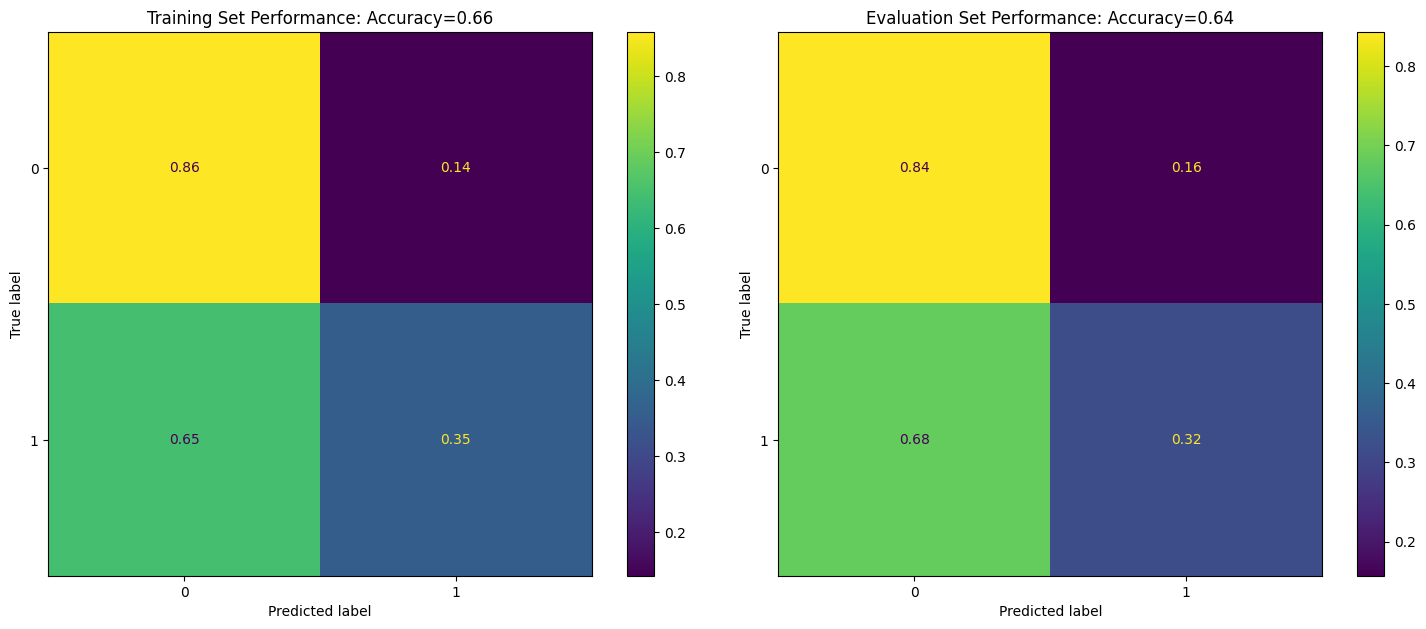


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      9243
           1       0.57      0.32      0.41      6000

    accuracy                           0.64     15243
   macro avg       0.61      0.58      0.57     15243
weighted avg       0.62      0.64      0.61     15243



In [45]:
eval_classification_performance(best_mlp, train_X_scaled, train_Y, test_X_scaled, test_Y)

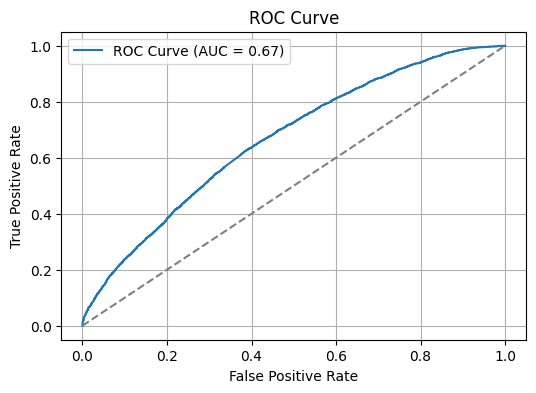

In [52]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_Y, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(test_Y, y_proba):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
X_test_enc = Encoded_test_X.copy()

for col in X_test_enc.select_dtypes(['category']).columns:
    X_test_enc[col] = X_test_enc[col].cat.set_categories(Encoded_train_X[col].cat.categories)
    X_test_enc[col] = X_test_enc[col].cat.codes

In [1]:
import shap

explainer = shap.Explainer(best_mlp.predict, train_X_scaled)
shap_values = explainer(X_test_enc)  # Note the parentheses instead of .shap_values()
shap.summary_plot(shap_values, test_X_scaled)


# Individual prediction explanation
shap.plots.waterfall(shap_values[0])  # for the first sample

# Visualize global feature importance
shap.plots.beeswarm(shap_values)

/home/theodc/git/CAPSTONE_T316/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'best_mlp' is not defined